## The "Problem Space"

Magic: the Gathering (MTG) is known for being a complex game with a rich history of mechanics and rules. We need to determine ways to objectively distinguish a card's value to gameplay.

### What's a "good" card?

In general, an MTG card is considered "better" in comparison to others when it:
- Is cheaper to cast
- Requires less specific colors to cast
- There are more opportunities to play it than other types (an instant is better than sorcery if all other attributes are the same)
- Creates greater "card advantage" (results in more cards for you than your opponent in hand or play)
- Has larger effects
- Has more effects
- Has effects that are not common for its color(s)
- Has a larger stat-line (power and toughness)

Additionally, cards that have or give "evergreen keywords" to creatures are typically seen as better because they produce more favorable results during combat. "Evasive" abilities such as flying or menace make creatures harder to block, defensive abilities like reach and vigilance make it harder for opponents to attack into you, and more lethal effects like deathtouch and first-strike complicate the math on both sides of combat.

## Importing Data

The following couple of cells will connect to your instance of Google Drive so that you can load in the dataset. It should be located in the same folder as this notebook, but Colab is bad and needs an absolute path.

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
csvPath = 'mtg-default-20240401.csv' # This line only for local
# csvPath = f'/content/drive/MyDrive/UMN/Classes/CSCI5525/{csvPath}'  # Dan
csvPath = f'/content/drive/MyDrive/CSCI5525/{csvPath}' # Ben


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
og = pd.read_csv(csvPath)
# The import process isn't perfect, fill NA with empty strings
og.fillna({ 'Mana Cost': '', 'Text': '' }, inplace = True)


In [ ]:
# Keep the original to view if needed
df = og.copy()
df.head()


,Name,Mana Cost,CMC,Type,Text,Power,Toughness,Lang,Border,Rarity,Released,Set Code,Set Type,Digital Only,Stamp,USD
0,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,en,black,uncommon,2006-10-06,tsp,expansion,False,NaN,0.41
1,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,en,black,common,2009-10-02,zen,expansion,False,NaN,0.16
2,Spirit,,0.0,Token Creature — Spirit,Flying,1,1,en,black,common,2015-05-22,tmm2,token,False,NaN,0.15
3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,en,black,common,2017-09-29,xln,expansion,False,NaN,0.03
4,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,NaN,NaN,en,white,rare,1994-04-01,3ed,core,False,NaN,0.67


### Data Scoping

The imported data is already partly cleaned, but there are more steps to be taken care of here. We will _eventually_ be removing duplicates, but we first need to narrow some scope of the cards that exist in this dataset. We will be removing:
- Non-english cards (cards that were printed in other languages "by default")
- Digital-only cards
- Cards outside the standard "core" and "expansion" sets, along with a few other major sets
- Tokens, because they are supplementary pieces and not required for gameplay.
- Cards that are "Special" rairity and are difficult to measure in value

Some of these removals are to help with calculating a baseline value later in the process.

In [ ]:
# Keep only English cards
print(f'Languages represented: {set(df["Lang"])}')
df.drop(df[df['Lang'] != 'en'].index, inplace = True)
df.drop(columns = ['Lang'], inplace = True)
print(f'After removing non-english records: {len(df)}')

# Remove cards not in core or expansion sets
df.drop(df[~df['Set Type'].isin(['core', 'expansion', 'masters', 'commander', 'promo', 'box'])].index, inplace = True)
df.drop(columns = ['Set Type'], inplace = True)
print(f'After removing non-core and expansion set records: {len(df)}')

# Remove tokens
df.drop(df[df['Type'].str.startswith('Token')].index, inplace = True)
print(f'After removing token records: {len(df)}')

# Remove what we THINK is digital-only, likely MTGO and MTGA printings
df.drop(df[df['Digital Only']].index, inplace = True)
df.drop(columns = ['Digital Only'], inplace = True)
print(f'After removing other digital only records: {len(df)}')

# Remove "Special" cards
df.drop(df[df['Rarity'] == 'special'].index, inplace = True)
print(f'After removing "Special" records: {len(df)}')

df.head()


Languages represented: {'ph', 'fr', 'pt', 'zht', 'sa', 'zhs', 'de', 'it', 'he', 'la', 'grc', 'en', 'ko', 'es', 'ar', 'ru', 'ja'}
After removing non-english records: 91395
After removing non-core and expansion set records: 69501
After removing token records: 69389
After removing other digital only records: 63036
After removing "Special" records: 62789


,Name,Mana Cost,CMC,Type,Text,Power,Toughness,Border,Rarity,Released,Set Code,Stamp,USD
0,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,black,uncommon,2006-10-06,tsp,NaN,0.41
1,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,black,common,2009-10-02,zen,NaN,0.16
3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,black,common,2017-09-29,xln,NaN,0.03
4,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,NaN,NaN,white,rare,1994-04-01,3ed,NaN,0.67
5,Surge of Brilliance,{1}{U},2.0,Instant,Paradox — Draw a card for each spell you've ca...,NaN,NaN,black,uncommon,2023-10-13,who,triangle,0.12


#### Seperation of Data

At this point, all of the data we want is in one dataframe. Some of this informationis redundant, and we want to narrow this down. For right now, we will seperate our dataframe into two logical tables:
- "Oracle cards" - all of the mechanically distinct information for a given game piece.
- "Card printings" - all of the supplemental data that can help us parse some idea of "value" for a given oracle card.

The joint column that these tables will share is the `Name` column due to the fact that everything about a card's oracle text is tied to it's name.

In [ ]:
oracle = df[['Name', 'Mana Cost', 'CMC', 'Type', 'Text', 'Power', 'Toughness']].copy()
oracle.head()


,Name,Mana Cost,CMC,Type,Text,Power,Toughness
0,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3
1,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2
3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2
4,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,NaN,NaN
5,Surge of Brilliance,{1}{U},2.0,Instant,Paradox — Draw a card for each spell you've ca...,NaN,NaN


In [ ]:
printings = df[['Name', 'Rarity', 'Released', 'Set Code', 'USD']].copy()
printings.head()


,Name,Rarity,Released,Set Code,USD
0,Fury Sliver,uncommon,2006-10-06,tsp,0.41
1,Kor Outfitter,common,2009-10-02,zen,0.16
3,Siren Lookout,common,2017-09-29,xln,0.03
4,Web,rare,1994-04-01,3ed,0.67
5,Surge of Brilliance,uncommon,2023-10-13,who,0.12


#### De-duplication of Oracle Data

The oracle table is now filled with _thousands_ of duplicate records that are not necessary to keep. We can easily remove these duplicate records.

We _won't_ do this for the printings simply because there could still be reasonable that a card was printed multiple times in the same set. This would impact the price, even if slightly, and could impact the final outputs.

In [ ]:
# Remove anything that's 100% duplicated, like cards with multiple arts
oracle.drop_duplicates(inplace = True)
print(f'Before dropping duplicate records: {len(df)}, After: {len(oracle)}')
print(f'Set Check by Name: {len(set(oracle["Name"]))}')


Before dropping duplicate records: 62789, After: 25534
Set Check by Name: 25534


### Data Cleaning

Now that the data has been scoped down and seperated, we will want to clean the oracle text to make any processing we do simpler.

#### Tokenizing Card Names

Sometimes a card's text will refer to itself. To make any data processing for this simpler, we'll replace any self-references with `CARDNAME`. This is easier said than done, however...

In [ ]:
nameToken = 'CARDNAME'
difficultNames = ['King Darien']  # Named characters that make life difficult.

# WotC likes to make this difficult...
def tokenizeName(row):
   # Fix the cases where the card has multiple faces (also works on normal, single-faced cards)
   faces = row['Name'].split(' // ')
   for f in faces:
      row['Text'] = row['Text'].replace(f, nameToken)
      # Legendary creatures are problematic...
      x = f.split(', ')
      if x[0] != f and x[0] in row['Text']:
         row['Text'] = row['Text'].replace(x[0], nameToken)
      else:
         x = f.split(' of ')
         if x[0] != f and x[0] in row['Text']:
            row['Text'] = row['Text'].replace(x[0], nameToken)
         else:
            x = f.split(' the ')
            if x[0] != f and x[0] in row['Text']:
               row['Text'] = row['Text'].replace(x[0], nameToken)
            else:
               # Take care of everyone that might have two-name subs
               for sub in difficultNames:
                  if sub in f:
                     row['Text'] = row['Text'].replace(sub, nameToken)
               # Then everyone else goes by their first name
               x = f.split(' ')
               if x[0] != f and x[0] in row['Text'] and 'Legendary ' in row['Type']:
                  row['Text'] = row['Text'].replace(x[0], nameToken)
   return row


In [ ]:
oracle = oracle.apply(lambda row: tokenizeName(row), axis = 1)
# At this point, we can just use the card names as the index for this table
oracle.set_index('Name', inplace = True)
oracle.head()


,Mana Cost,CMC,Type,Text,Power,Toughness
Name,,,,,,
Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3
Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When CARDNAME enters the battlefield, you may ...",2,2
Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,"Flying\nWhen CARDNAME enters the battlefield, ...",1,2
Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,NaN,NaN
Surge of Brilliance,{1}{U},2.0,Instant,Paradox — Draw a card for each spell you've ca...,NaN,NaN


#### Other Text Sanitization

There are some minor inconsitencies in the characters used in some strings, and it would be helpful when parsing to simply standardize away some of them, such as dashes vs minus symbols.

There are three dashes that are used, `-` (minus), `−` (en dash), and `—` (em dash). The first is used to represent power-toughness changes. The second is used in changes to Planeswalker loyalty. The last is used to seperate an ability from it's explaination. We will be simplifying by removing en dashes and replacing them with minus because they are doing roughtly the same thing, mechanically.

Minus is also used to space between numbers in things like level cards and rolling d20 outcomes. These minus symbols should be replaced with em dashes.

In [ ]:
from re import sub

def standardizeDashes(row):
   # Always remove en dashes
   row['Text'] = row['Text'].replace('−', '-')
   # Sometimes fix minuses to em dashes
   row['Text'] = sub(r'(?<=\d)-(?=\d)', '—', row['Text'])
   return row


In [ ]:
oracle = oracle.apply(lambda row: standardizeDashes(row), axis = 1)
oracle.head()


,Mana Cost,CMC,Type,Text,Power,Toughness
Name,,,,,,
Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3
Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When CARDNAME enters the battlefield, you may ...",2,2
Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,"Flying\nWhen CARDNAME enters the battlefield, ...",1,2
Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,NaN,NaN
Surge of Brilliance,{1}{U},2.0,Instant,Paradox — Draw a card for each spell you've ca...,NaN,NaN


There are also some characters which are simply variations from common characters. These replacements should be done throughout the whole dataset. One example is the use of `’` over the common `'`.

Another is that some em dashes are surrounded by spaces and others aren't. This will be normalized to no spaces.

There seems to be a leading space (likely on accident) at the beginning of some lines of text which should be removed.

In [ ]:
oracle.replace({
   '’': '\'',
   ' —': '—',
   '— ': '—',
   '^ ': '',
   '\n ': '\n'}, regex = True, inplace = True)


## Generating Supplemental Data

There's a few more things we can do to make data synthesis easier.

### Counting Prints Per Oracle

As was implied in previous sections, a single oracle card can be printed repeatedly in various sets (or with multiple arts/styles in the same set) but be otherwise functionally the same card. For our metrics, we are attempting to derive some quanitfiable measure to asses the power or utility of any given oracle card. Our only facimily at this point is secondary market data, which comes with it's own set of problems.

If we want to do any kind of analysis that involves smoothing out these problems, it will be helpful to know how many times each oracle card has been printed. Additionally, it may be worth checking how many of each rarity were printed. (It is possible for the rarity to change from printing to printing to help balance the rest of the set.)

_Note: `Special` rarity contains instances like invocations or "time-shifted" cards where the art is different. These are difficult to estimate importance as a group, since things like invocations were rare while time-shifted cards may have had varying rarities. **These have already been dropped.**_

In general, the order of least to most available for other rarities goes in order of `Common`, `Uncommon`, `Rare`, and `Mythic`.

In [ ]:
# The nice order for these columns
rarityList = ['common', 'uncommon', 'rare', 'mythic']


### Creating a Ground-Truth

Second-hand market price is a relatively... _fine_ indicator for a card being desireable for play. They are not perfect, and do need some adjustment, but it's the data that's available.

A card _might_ be priced high because:
- It hasn't been printed in many sets (hard to get)
- A particular printing is "more aesthetic" (foil prints, alternate arts, borderless, etc.)
- The card is actually good

An arbitrary "good" card might be priced lower than another arbitrary "bad" card simply because the "good" card was printed a lot and is considered a staple in the format. We will likely have to consider a few different things to come up with an **adjusted market value**:
- Should the starting base price come from a pure average, weighted average (using "rarity" of the print), or some other metric?
- Should there be some kind of exponential decay $\left(\frac{1}{e^x}\right)$ based on how "available" the card is in general (not specific to a particular printing)?
- How should we handle clear outliers in the data, such as where there is only one printing, where some printings are disproportionally high in comparison to others for the same card, or where no pricing data is available?

#### "Normalizing" from Imperfect Metrics

As stated before, USD is a less-than perfect indicator of a card's utility in the game. We will first need a way to "normalize" values such that superficial reasons for a card's price are diminished. We will take the following approach:
- Assess a trimmed mean and standard deviation of printings of **a particular set and rarity**. Trimmed means will allow for us to remove the most problematic prices, and the remaining standard deviation will help set a scaling factor.
- Drop records that don't have an original price, a resulting mean, or a standard deviation that is too low. We simply can't calculate a scale without these.
- Drop records where there's only a couple printings after other drops. There's not enough data to stabilize a single value for the oracle card.
- Establish a basic modified value scale using the calculated means and standard deviations from the first step.
- Rein-in the outliers to reduce the scope of the scale and make the differences in "good" cards stronger than "great" cards.
- Average the resulting scores amongst the printings of each oracle and apply them to the oracle table.

In [ ]:
import numpy as np
from scipy.stats import trimboth

def trimStd(series, cut = 0.1):
   return np.nanstd(trimboth(series, cut))

def trimMean(series, cut = 0.1):
   return np.nanmean(trimboth(series, cut))


In [ ]:
# Calculate stats based on set and rarity
setStats = pd.pivot_table(
   printings[['Set Code', 'Rarity', 'USD']],
   index = ['Set Code', 'Rarity'],
   values = 'USD',
   aggfunc = [trimMean, trimStd]
)

# Remove unnecessary level
setStats.columns = setStats.columns.droplevel(-1)

# Reset index to make merge easier
setStats = setStats.reset_index()

setStats.head()


<ipython-input-14-37bba890f1b1>:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(trimboth(series, cut))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,Set Code,Rarity,trimMean,trimStd
0,10e,common,0.161057,0.110607
1,10e,rare,3.168667,4.110068
2,10e,uncommon,0.442692,0.714223
3,2ed,common,1.189167,0.906154
4,2ed,rare,189.705053,303.120571


In [ ]:
# Apply the stats to the whole frame
printings = printings.merge(setStats, on = ['Set Code', 'Rarity'])
printings.head()


,Name,Rarity,Released,Set Code,USD,trimMean,trimStd
0,Fury Sliver,uncommon,2006-10-06,tsp,0.41,0.256094,0.128058
1,Paradise Plume,uncommon,2006-10-06,tsp,0.31,0.256094,0.128058
2,Sudden Death,uncommon,2006-10-06,tsp,0.23,0.256094,0.128058
3,Smallpox,uncommon,2006-10-06,tsp,0.45,0.256094,0.128058
4,Vampiric Sliver,uncommon,2006-10-06,tsp,0.69,0.256094,0.128058


In [ ]:
# We can't adjust values that don't exist
mod = printings.dropna(subset = ['USD', 'trimMean'])
mod.drop(mod[mod['trimStd'] < 0.01].index, inplace = True)
mod


<ipython-input-17-a86d3930ffab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod.drop(mod[mod['trimStd'] < 0.01].index, inplace = True)


,Name,Rarity,Released,Set Code,USD,trimMean,trimStd
0,Fury Sliver,uncommon,2006-10-06,tsp,0.41,0.256094,0.128058
1,Paradise Plume,uncommon,2006-10-06,tsp,0.31,0.256094,0.128058
2,Sudden Death,uncommon,2006-10-06,tsp,0.23,0.256094,0.128058
3,Smallpox,uncommon,2006-10-06,tsp,0.45,0.256094,0.128058
4,Vampiric Sliver,uncommon,2006-10-06,tsp,0.69,0.256094,0.128058
...,...,...,...,...,...,...,...
60166,Wrong Turn,rare,2024-02-09,pcmr,0.58,10.560000,9.980000
60173,Mystical Dispute,rare,2023-01-07,pr23,2.93,3.270000,0.340000
60174,Thing in the Ice // Awoken Horror,rare,2023-01-07,pr23,3.61,3.270000,0.340000
60184,Selfless Spirit,rare,2022-10-01,prcq,5.25,3.515000,1.735000


In [ ]:
# We also should drop things that only have a couple records now, they are too unstable.
mod = mod[mod.groupby(['Name'])['Name'].transform('size') > 3]
mod


,Name,Rarity,Released,Set Code,USD,trimMean,trimStd
5,Saltcrusted Steppe,uncommon,2006-10-06,tsp,0.23,0.256094,0.128058
18,Return to Dust,uncommon,2006-10-06,tsp,0.18,0.256094,0.128058
19,Undying Rage,uncommon,2006-10-06,tsp,0.07,0.256094,0.128058
21,Krosan Grip,uncommon,2006-10-06,tsp,0.73,0.256094,0.128058
30,Sulfurous Blast,uncommon,2006-10-06,tsp,0.30,0.256094,0.128058
...,...,...,...,...,...,...,...
60151,Sunken Hollow,rare,2015-10-02,pss1,5.52,4.164000,0.707152
60152,Prairie Stream,rare,2015-10-02,pss1,3.46,4.164000,0.707152
60156,Lurrus of the Dream-Den,rare,2021-10-15,q06,0.99,1.355000,1.277664
60158,Approach of the Second Sun,rare,2021-10-15,q06,3.50,1.355000,1.277664


In [ ]:
# Scale the values towards their set means
mod['Mod USD'] = ((mod['USD'] - mod['trimMean']) / mod['trimStd'])
mod

<ipython-input-19-913d8de9833b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod['Mod USD'] = ((mod['USD'] - mod['trimMean']) / mod['trimStd'])


,Name,Rarity,Released,Set Code,USD,trimMean,trimStd,Mod USD
5,Saltcrusted Steppe,uncommon,2006-10-06,tsp,0.23,0.256094,0.128058,-0.203765
18,Return to Dust,uncommon,2006-10-06,tsp,0.18,0.256094,0.128058,-0.594214
19,Undying Rage,uncommon,2006-10-06,tsp,0.07,0.256094,0.128058,-1.453201
21,Krosan Grip,uncommon,2006-10-06,tsp,0.73,0.256094,0.128058,3.700721
30,Sulfurous Blast,uncommon,2006-10-06,tsp,0.30,0.256094,0.128058,0.342863
...,...,...,...,...,...,...,...,...
60151,Sunken Hollow,rare,2015-10-02,pss1,5.52,4.164000,0.707152,1.917551
60152,Prairie Stream,rare,2015-10-02,pss1,3.46,4.164000,0.707152,-0.995543
60156,Lurrus of the Dream-Den,rare,2021-10-15,q06,0.99,1.355000,1.277664,-0.285678
60158,Approach of the Second Sun,rare,2021-10-15,q06,3.50,1.355000,1.277664,1.678845


Stop for a moment to check on the extreme ends of the scale so far.

In [ ]:
mod.query('`Mod USD` < -1').sort_values('Mod USD', ascending = True)

,Name,Rarity,Released,Set Code,USD,trimMean,trimStd,Mod USD
42488,Combustible Gearhulk,mythic,2016-09-30,pkld,1.77,3.856667,0.299481,-6.967609
58289,In Garruk's Wake,rare,2014-07-17,pm15,2.05,3.115000,0.155000,-6.870968
8344,Concealed Courtyard,rare,2024-04-19,otj,1.00,14.570000,3.678668,-3.688836
8350,Botanical Sanctum,rare,2024-04-19,otj,3.99,14.570000,3.678668,-2.876041
54178,Star of Extinction,mythic,2017-09-29,pxln,3.07,7.640000,1.900000,-2.405263
...,...,...,...,...,...,...,...,...
22382,Femeref Archers,uncommon,1999-04-21,6ed,0.12,0.257045,0.136932,-1.000829
22346,Iron Star,uncommon,1999-04-21,6ed,0.12,0.257045,0.136932,-1.000829
22384,Ivory Cup,uncommon,1999-04-21,6ed,0.12,0.257045,0.136932,-1.000829
50766,Lightning Bolt,rare,2019-01-01,pf19,3.38,3.495000,0.115000,-1.000000


In [ ]:
mod.query('`Mod USD` > 1').sort_values('Mod USD', ascending = False)

,Name,Rarity,Released,Set Code,USD,trimMean,trimStd,Mod USD
54546,Ancient Tomb,uncommon,1997-10-14,tmp,95.59,0.349091,0.241174,394.904750
43627,Aura Shards,uncommon,2000-10-02,inv,18.55,0.224659,0.079543,230.381591
39384,Strip Mine,uncommon,1995-04-01,4ed,18.84,0.211546,0.097909,190.261980
54591,Wasteland,uncommon,1997-10-14,tmp,42.33,0.349091,0.241174,174.068691
24483,Sensei's Divining Top,uncommon,2004-10-01,chk,25.04,0.239178,0.171238,144.832073
...,...,...,...,...,...,...,...,...
43747,Forest,common,2006-10-06,tsp,0.23,0.162124,0.067699,1.002622
26768,Rancor,uncommon,2016-06-10,ema,1.02,0.476094,0.543141,1.001409
48890,Diluvian Primordial,rare,2013-02-01,gtc,2.83,1.136512,1.691896,1.000941
46173,Greed,uncommon,2021-04-23,c21,0.51,0.261905,0.248077,1.000072


In [ ]:
# Apply a limiting function to reduce the exponential strength of outliers
mod['Score'] = mod.apply(
   lambda x: np.sqrt(x['Mod USD'])
      if x['Mod USD'] >= 0
      else -np.imag(np.emath.sqrt(x['Mod USD'])),
   axis = 1
)

mod = mod.round(5)


<ipython-input-22-951c3f093265>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod['Score'] = mod.apply(


In [ ]:
mod.query('`Score` < 0').sort_values('Score', ascending = True)

,Name,Rarity,Released,Set Code,USD,trimMean,trimStd,Mod USD,Score
42488,Combustible Gearhulk,mythic,2016-09-30,pkld,1.77,3.85667,0.29948,-6.96761,-2.63962
58289,In Garruk's Wake,rare,2014-07-17,pm15,2.05,3.11500,0.15500,-6.87097,-2.62125
8344,Concealed Courtyard,rare,2024-04-19,otj,1.00,14.57000,3.67867,-3.68884,-1.92063
8350,Botanical Sanctum,rare,2024-04-19,otj,3.99,14.57000,3.67867,-2.87604,-1.69589
54178,Star of Extinction,mythic,2017-09-29,pxln,3.07,7.64000,1.90000,-2.40526,-1.55089
...,...,...,...,...,...,...,...,...,...
40230,Serra Angel,uncommon,2023-01-13,dmr,0.10,0.10010,0.08989,-0.00116,-0.03404
40198,Congregate,uncommon,2023-01-13,dmr,0.10,0.10010,0.08989,-0.00116,-0.03404
40134,Flametongue Kavu,uncommon,2023-01-13,dmr,0.10,0.10010,0.08989,-0.00116,-0.03404
44525,Akoum Refuge,uncommon,2019-08-23,c19,0.21,0.21016,0.17203,-0.00094,-0.03062


In [ ]:
mod.query('`Score` > 1').sort_values('Score', ascending = False)

,Name,Rarity,Released,Set Code,USD,trimMean,trimStd,Mod USD,Score
54546,Ancient Tomb,uncommon,1997-10-14,tmp,95.59,0.34909,0.24117,394.90475,19.87221
43627,Aura Shards,uncommon,2000-10-02,inv,18.55,0.22466,0.07954,230.38159,15.17833
39384,Strip Mine,uncommon,1995-04-01,4ed,18.84,0.21155,0.09791,190.26198,13.79355
54591,Wasteland,uncommon,1997-10-14,tmp,42.33,0.34909,0.24117,174.06869,13.19351
24483,Sensei's Divining Top,uncommon,2004-10-01,chk,25.04,0.23918,0.17124,144.83207,12.03462
...,...,...,...,...,...,...,...,...,...
45873,"Elesh Norn, Mother of Machines",mythic,2023-02-03,one,27.63,15.28355,12.30691,1.00321,1.00161
43747,Forest,common,2006-10-06,tsp,0.23,0.16212,0.06770,1.00262,1.00131
26768,Rancor,uncommon,2016-06-10,ema,1.02,0.47609,0.54314,1.00141,1.00070
48890,Diluvian Primordial,rare,2013-02-01,gtc,2.83,1.13651,1.69190,1.00094,1.00047


In [ ]:
# Get the calculated mean from the scaled values, this will be the ground-truth.
scale = mod.groupby('Name').agg({'Score': 'mean'})
scale.sort_values(by = ['Score'], ascending = False).head(20)


,Score
Name,
Ancient Tomb,9.044688
Aura Shards,7.509148
Elemental Bond,6.604043
Priest of Titania,6.534575
Enlightened Tutor,5.813861
Arcane Denial,5.294745
Worldly Tutor,5.240616
Buried Alive,5.215404
Pongify,5.160720


In [ ]:
# Add the new score into the oracle table
oracle = oracle.merge(scale, on = ['Name'], how = 'left')
oracle

,Mana Cost,CMC,Type,Text,Power,Toughness,Score
Name,,,,,,,
Fury Sliver,{5}{R},6.0,Creature—Sliver,All Sliver creatures have double strike.,3,3,NaN
Kor Outfitter,{W}{W},2.0,Creature—Kor Soldier,"When CARDNAME enters the battlefield, you may ...",2,2,NaN
Siren Lookout,{2}{U},3.0,Creature—Siren Pirate,"Flying\nWhen CARDNAME enters the battlefield, ...",1,2,NaN
Web,{G},1.0,Enchantment—Aura,Enchant creature (Target a creature as you cas...,NaN,NaN,-0.7121
Surge of Brilliance,{1}{U},2.0,Instant,Paradox—Draw a card for each spell you've cast...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
Youthful Valkyrie,{1}{W},2.0,Creature—Angel,Flying\nWhenever another Angel enters the batt...,1,3,NaN
Fallaji Vanguard,{2}{R}{W},4.0,Creature—Human Soldier,First strike\nWhenever CARDNAME or another cre...,2,3,NaN
Hold at Bay,{1}{W},2.0,Instant,Prevent the next 7 damage that would be dealt ...,NaN,NaN,NaN


In [ ]:
oracle.dropna(subset = ['Score'])

,Mana Cost,CMC,Type,Text,Power,Toughness,Score
Name,,,,,,,
Web,{G},1.0,Enchantment—Aura,Enchant creature (Target a creature as you cas...,NaN,NaN,-0.712100
Swamp,,0.0,Basic Land—Swamp,({T}: Add {B}.),NaN,NaN,0.887544
Birds of Paradise,{G},1.0,Creature—Bird,Flying\n{T}: Add one mana of any color.,0,1,1.045966
Admiral Beckett Brass,{1}{U}{B}{R},4.0,Legendary Creature—Human Pirate,Other Pirates you control get +1/+1.\nAt the b...,3,3,-0.774765
Mulch,{1}{G},2.0,Sorcery,Reveal the top four cards of your library. Put...,NaN,NaN,-0.277500
...,...,...,...,...,...,...,...
Zombie Infestation,{1}{B},2.0,Enchantment,Discard two cards: Create a 2/2 black Zombie c...,NaN,NaN,-0.250848
Fishliver Oil,{1}{U},2.0,Enchantment—Aura,Enchant creature (Target a creature as you cas...,NaN,NaN,-0.425292
Drift of Phantasms,{2}{U},3.0,Creature—Spirit,Defender (This creature can't attack.)\nFlying...,0,5,3.103745


In [ ]:
# Save the data for later, just in case.
oracle.to_csv('oracle.csv')

## Designing the Model

Our goal is to design a model that, given the card details, can return one value that signifies the strength of a card.

In [ ]:
# Copy the oracle data over to construct the training data
train_data = oracle.copy()
train_data.head()

,Mana Cost,CMC,Type,Text,Power,Toughness,Score
Name,,,,,,,
Fury Sliver,{5}{R},6.0,Creature—Sliver,All Sliver creatures have double strike.,3,3,NaN
Kor Outfitter,{W}{W},2.0,Creature—Kor Soldier,"When CARDNAME enters the battlefield, you may ...",2,2,NaN
Siren Lookout,{2}{U},3.0,Creature—Siren Pirate,"Flying\nWhen CARDNAME enters the battlefield, ...",1,2,NaN
Web,{G},1.0,Enchantment—Aura,Enchant creature (Target a creature as you cas...,NaN,NaN,-0.7121
Surge of Brilliance,{1}{U},2.0,Instant,Paradox—Draw a card for each spell you've cast...,NaN,NaN,NaN


In [ ]:
def separateTypes(row):
  # Test to see if there is a sub-type
  rowType = row['Type']
  if '—' in rowType:
    row['Type'] = ''
    row['subType'] = ''
  # Test for multiple types and sub-types
  if '//' in rowType:
    types = rowType.split('//')
  else:
    types = [rowType]
  # Separate each type into Type and subType
  for item in types:
    if '—' in item:
      [Type, subType] = item.split('—')
      # If there exists a type already, then add a separator (//) and add the second type to the type name
      if row['Type'] != '':
        row['Type'] = row['Type'] + ' // ' + Type.strip()
      else:
        row['Type'] += Type.strip()
      # If there exists a sub-type already, then add a separator (//) and add the second sub-type to the sub-type name
      if row['subType'] != '':
        row['subType'] = row['subType'] + ' // ' + subType.strip()
      else:
        row['subType'] += subType.strip()
  return row


In [ ]:
train_data = train_data.apply(lambda row: separateTypes(row), axis = 1)
train_data.head(10)

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType
Name,,,,,,,,
Fury Sliver,6.0,{5}{R},3,NaN,All Sliver creatures have double strike.,3,Creature,Sliver
Kor Outfitter,2.0,{W}{W},2,NaN,"When CARDNAME enters the battlefield, you may ...",2,Creature,Kor Soldier
Siren Lookout,3.0,{2}{U},1,NaN,"Flying\nWhen CARDNAME enters the battlefield, ...",2,Creature,Siren Pirate
Web,1.0,{G},NaN,-0.712100,Enchant creature (Target a creature as you cas...,NaN,Enchantment,Aura
Surge of Brilliance,2.0,{1}{U},NaN,NaN,Paradox—Draw a card for each spell you've cast...,NaN,Instant,NaN
Obyra's Attendants // Desperate Parry,5.0,{4}{U} // {1}{U},3,NaN,Flying // Target creature gets -4/-0 until end...,4,Creature // Instant,Faerie Wizard // Adventure
Venerable Knight,1.0,{W},2,NaN,"When CARDNAME dies, put a +1/+1 counter on tar...",1,Creature,Human Knight
Wildcall,2.0,{X}{G}{G},NaN,NaN,"Manifest the top card of your library, then pu...",NaN,Sorcery,NaN
Mystic Skyfish,3.0,{2}{U},3,NaN,"Whenever you draw your second card each turn, ...",1,Creature,Fish


### Vectorizing the Data

In order to feed the data into the model, the features of the card need to be vectorized properly. The types and the mana cost can be encoded, but the text of the card is the piece that would not be so simple and will likely require its own section. We will get to that later.

In [ ]:
# FOR TESTING UNIQUE TYPES/SUBTYPES
len(train_data['Type'].unique())
len(train_data['Mana Cost'].unique())
len(train_data['subType'].unique())
train_data['Type'].unique()
train_data['subType'].unique()[:10]

array(['Sliver', 'Kor Soldier', 'Siren Pirate', 'Aura', nan,
       'Faerie Wizard // Adventure', 'Human Knight', 'Fish', 'Swamp',
       'Bird Wizard'], dtype=object)

In [ ]:
# Vectorizing Mana Cost
# C W U B R G -- Types and their positions
def vectorizeMana(row):
  manaStr = row['Mana Cost']
  outputVec = [0, 0, 0, 0, 0, 0]
  charToIdx = {'C': 0, 'S': 0, 'W': 1, 'U': 2, 'B': 3, 'R': 4, 'G': 5}
  newString = manaStr.replace(' // ', '').replace('X', '').replace('P', '').strip('{} ')
  manaList = newString.split('}{')
  for mana in manaList:
    if mana == '':
      continue
    if mana.isnumeric():
      outputVec[0] += int(mana)
    else:
      if '/' in mana:
        # Split the mana that is divided and divide by the total amount that is split
        splitMana = mana.split('/')
        for partialMana in splitMana:
          if partialMana == '':
            continue
          if partialMana.isnumeric():
            outputVec[0] += int(partialMana)/len(splitMana)
          else:
            outputVec[charToIdx[partialMana]] += 1/len(splitMana)
      else:
        outputVec[charToIdx[mana]] += 1
  row['Mana Cost'] = outputVec
  return row

In [ ]:
train_data = train_data.apply(lambda row: vectorizeMana(row), axis = 1)
train_data.head(10)

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType
Name,,,,,,,,
Fury Sliver,6.0,"[5, 0, 0, 0, 1, 0]",3,NaN,All Sliver creatures have double strike.,3,Creature,Sliver
Kor Outfitter,2.0,"[0, 2, 0, 0, 0, 0]",2,NaN,"When CARDNAME enters the battlefield, you may ...",2,Creature,Kor Soldier
Siren Lookout,3.0,"[2, 0, 1, 0, 0, 0]",1,NaN,"Flying\nWhen CARDNAME enters the battlefield, ...",2,Creature,Siren Pirate
Web,1.0,"[0, 0, 0, 0, 0, 1]",NaN,-0.712100,Enchant creature (Target a creature as you cas...,NaN,Enchantment,Aura
Surge of Brilliance,2.0,"[1, 0, 1, 0, 0, 0]",NaN,NaN,Paradox—Draw a card for each spell you've cast...,NaN,Instant,NaN
Obyra's Attendants // Desperate Parry,5.0,"[5, 0, 2, 0, 0, 0]",3,NaN,Flying // Target creature gets -4/-0 until end...,4,Creature // Instant,Faerie Wizard // Adventure
Venerable Knight,1.0,"[0, 1, 0, 0, 0, 0]",2,NaN,"When CARDNAME dies, put a +1/+1 counter on tar...",1,Creature,Human Knight
Wildcall,2.0,"[0, 0, 0, 0, 0, 2]",NaN,NaN,"Manifest the top card of your library, then pu...",NaN,Sorcery,NaN
Mystic Skyfish,3.0,"[2, 0, 1, 0, 0, 0]",3,NaN,"Whenever you draw your second card each turn, ...",1,Creature,Fish


## Representing Types as Keywords

Due to each of the unique types that exist for cards in Magic: The Gathering, we can encode each of the types as a set of keywords where the keywords use word embeddings that are passed into the model. In order to do this, we need to get the vocab size of the types and subtypes.

In [ ]:
import math

def getVocabSize(types):
  totalKeywords = []
  for item in types:
    # Check the item type to avoid NaN errors
    if type(item) == str:
      for keyword in item.replace('//', '').split():
        totalKeywords.append(keyword)
  return len(set(totalKeywords))

In [ ]:
getVocabSize(train_data['Type'].unique())
getVocabSize(train_data['subType'].unique())

452

In [ ]:
import numpy as np

allTypes = []
for types in train_data['Type'].unique():
  for uniqueType in types.replace('//', '').split():
    if uniqueType not in allTypes:
      allTypes.append(uniqueType)

print(len(allTypes))
typeKeywords = dict.fromkeys(allTypes, 0)
total = 0
for key in typeKeywords.keys():
  typeKeywords[key] = total
  total += 1

print(typeKeywords)

def vectorizeTypes(row):
  typeVec = np.zeros(len(allTypes))
  # Check the item type to avoid NaN errors
  if type(row['Type']) == str:
    for keyword in row['Type'].replace('//', '').split():
      typeVec[typeKeywords[keyword]] += 1
  row['Type'] = typeVec
  return row

21
{'Creature': 0, 'Enchantment': 1, 'Instant': 2, 'Sorcery': 3, 'Basic': 4, 'Land': 5, 'Legendary': 6, 'Planeswalker': 7, 'Artifact': 8, 'Battle': 9, 'Snow': 10, 'World': 11, 'Tribal': 12, 'Plane': 13, 'Phenomenon': 14, 'Scheme': 15, 'Card': 16, 'Emblem': 17, 'Token': 18, 'Ongoing': 19, 'Conspiracy': 20}


In [ ]:
train_data = train_data.apply(lambda row: vectorizeTypes(row), axis = 1)
train_data.head()

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType
Name,,,,,,,,
Fury Sliver,6.0,"[5, 0, 0, 0, 1, 0]",3,NaN,All Sliver creatures have double strike.,3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sliver
Kor Outfitter,2.0,"[0, 2, 0, 0, 0, 0]",2,NaN,"When CARDNAME enters the battlefield, you may ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Kor Soldier
Siren Lookout,3.0,"[2, 0, 1, 0, 0, 0]",1,NaN,"Flying\nWhen CARDNAME enters the battlefield, ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Siren Pirate
Web,1.0,"[0, 0, 0, 0, 0, 1]",NaN,-0.7121,Enchant creature (Target a creature as you cas...,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Aura
Surge of Brilliance,2.0,"[1, 0, 1, 0, 0, 0]",NaN,NaN,Paradox—Draw a card for each spell you've cast...,NaN,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN


In [ ]:
import numpy as np

allSubTypes = []
for types in train_data['subType'].unique():
  if type(types) == str:
    for uniqueSubType in types.replace('//', '').split():
      if uniqueSubType not in allSubTypes:
        allSubTypes.append(uniqueSubType)

print(len(allSubTypes))
subTypeKeywords = dict.fromkeys(allSubTypes, 0)
total = 0
for key in subTypeKeywords.keys():
  subTypeKeywords[key] = total
  total += 1

print(subTypeKeywords)

def vectorizeSubTypes(row):
  subTypeVec = np.zeros(len(allSubTypes))
  # Check the item type to avoid NaN errors
  if type(row['subType']) == str:
    for keyword in row['subType'].replace('//', '').split():
      subTypeVec[subTypeKeywords[keyword]] += 1
  row['subType'] = subTypeVec
  return row

452
{'Sliver': 0, 'Kor': 1, 'Soldier': 2, 'Siren': 3, 'Pirate': 4, 'Aura': 5, 'Faerie': 6, 'Wizard': 7, 'Adventure': 8, 'Human': 9, 'Knight': 10, 'Fish': 11, 'Swamp': 12, 'Bird': 13, 'Snake': 14, 'Wall': 15, 'Lizard': 16, 'Hydra': 17, 'Plant': 18, 'Dinosaur': 19, 'Monk': 20, 'Vampire': 21, 'Assassin': 22, 'Gate': 23, 'Narset': 24, 'Elf': 25, 'Druid': 26, 'Island': 27, 'Equipment': 28, 'Rogue': 29, 'Archon': 30, 'Phyrexian': 31, 'Gremlin': 32, 'Construct': 33, 'Eldrazi': 34, 'Kavu': 35, 'Brushwagg': 36, 'Mount': 37, 'Goblin': 38, 'Shaman': 39, 'Siege': 40, 'Shapeshifter': 41, 'Plains': 42, 'Archer': 43, 'Beeble': 44, 'Hellion': 45, 'Mutant': 46, 'Scout': 47, 'Ally': 48, 'Kirin': 49, 'Spirit': 50, 'Cat': 51, 'Nightmare': 52, 'Thopter': 53, 'Barbarian': 54, 'Zombie': 55, 'Advisor': 56, 'Artificer': 57, 'Dragon': 58, 'Skeleton': 59, 'Dwarf': 60, 'Rhino': 61, 'Warrior': 62, 'Imp': 63, 'Elder': 64, 'Vehicle': 65, 'Moonfolk': 66, 'Mountain': 67, 'Vedalken': 68, 'Kraken': 69, 'Giant': 70, 'Rat

In [ ]:
train_data = train_data.apply(lambda row: vectorizeSubTypes(row), axis = 1)
train_data.head()

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType
Name,,,,,,,,
Fury Sliver,6.0,"[5, 0, 0, 0, 1, 0]",3,NaN,All Sliver creatures have double strike.,3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Kor Outfitter,2.0,"[0, 2, 0, 0, 0, 0]",2,NaN,"When CARDNAME enters the battlefield, you may ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Siren Lookout,3.0,"[2, 0, 1, 0, 0, 0]",1,NaN,"Flying\nWhen CARDNAME enters the battlefield, ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
Web,1.0,"[0, 0, 0, 0, 0, 1]",NaN,-0.7121,Enchant creature (Target a creature as you cas...,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
Surge of Brilliance,2.0,"[1, 0, 1, 0, 0, 0]",NaN,NaN,Paradox—Draw a card for each spell you've cast...,NaN,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
import numpy as np

allText = []
for text in train_data['Text'].unique():
  if type(text) == str:
    for uniqueText in text.replace('//', '').split():
      if uniqueText not in allText:
        allText.append(uniqueText)

print(len(allText))
textKeywords = dict.fromkeys(allText, 0)
total = 0
for key in textKeywords.keys():
  textKeywords[key] = total
  total += 1

print(textKeywords)

def vectorizeText(row):
  textVec = np.zeros(len(allText))
  # Check the item type to avoid NaN errors
  if type(row['Text']) == str:
    for keyword in row['Text'].replace('//', '').split():
      textVec[textKeywords[keyword]] += 1
  row['textVec'] = textVec
  return row

6922
{'All': 0, 'Sliver': 1, 'creatures': 2, 'have': 3, 'double': 4, 'strike.': 5, 'When': 6, 'CARDNAME': 7, 'enters': 8, 'the': 9, 'battlefield,': 10, 'you': 11, 'may': 12, 'attach': 13, 'target': 14, 'Equipment': 15, 'control': 16, 'to': 17, 'creature': 18, 'control.': 19, 'Flying': 20, 'it': 21, 'explores.': 22, '(Reveal': 23, 'top': 24, 'card': 25, 'of': 26, 'your': 27, 'library.': 28, 'Put': 29, 'that': 30, 'into': 31, 'hand': 32, 'if': 33, "it's": 34, 'a': 35, 'land.': 36, 'Otherwise,': 37, 'put': 38, '+1/+1': 39, 'counter': 40, 'on': 41, 'this': 42, 'creature,': 43, 'then': 44, 'back': 45, 'or': 46, 'graveyard.)': 47, 'Enchant': 48, '(Target': 49, 'as': 50, 'cast': 51, 'this.': 52, 'This': 53, 'battlefield': 54, 'attached': 55, 'creature.)': 56, 'Enchanted': 57, 'gets': 58, '+0/+2': 59, 'and': 60, 'has': 61, 'reach.': 62, '(It': 63, 'can': 64, 'block': 65, 'with': 66, 'flying.)': 67, 'Paradox—Draw': 68, 'for': 69, 'each': 70, 'spell': 71, "you've": 72, 'turn': 73, 'from': 74, 'a

In [ ]:
train_data = train_data.apply(lambda row: vectorizeText(row), axis = 1)
train_data.head()

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType,textVec
Name,,,,,,,,,
Fury Sliver,6.0,"[5, 0, 0, 0, 1, 0]",3,NaN,All Sliver creatures have double strike.,3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
Kor Outfitter,2.0,"[0, 2, 0, 0, 0, 0]",2,NaN,"When CARDNAME enters the battlefield, you may ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
Siren Lookout,3.0,"[2, 0, 1, 0, 0, 0]",1,NaN,"Flying\nWhen CARDNAME enters the battlefield, ...",2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
Web,1.0,"[0, 0, 0, 0, 0, 1]",NaN,-0.7121,Enchant creature (Target a creature as you cas...,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
Surge of Brilliance,2.0,"[1, 0, 1, 0, 0, 0]",NaN,NaN,Paradox—Draw a card for each spell you've cast...,NaN,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Goal is to onehot encode power and toughness. Need to find maximum to do so
maxPower = float('-inf')
for power in train_data['Power']:
  if type(power) == str:
    if '*' in power:
      continue
    if '//' in power:
      power1, power2 = power.split('//')
      power = (float(power1) + float(power2))/2
  if float(power) > maxPower:
    maxPower = float(power)
print(maxPower)

maxToughness = float('-inf')
for toughness in train_data['Toughness']:
  if type(toughness) == str:
    if '*' in toughness:
      continue
    if '//' in toughness:
      toughness1, toughness2 = toughness.split('//')
      toughness = (float(toughness1) + float(toughness2))/2
  if float(toughness) > maxToughness:
    maxToughness = float(toughness)
print(maxToughness)

18.0
17.0


In [ ]:
def vectorizePower(row):
  powerVec = np.zeros(19)
  power = row['Power']
  if type(power) == str:
    if '*' in power:
      power = '0'
    if '//' in power:
      power1, power2 = power.split('//')
      power = (float(power1) + float(power2))/2
    powerVec[int(power)] = 1
  row['Power'] = powerVec
  return row

def vectorizeToughness(row):
  toughnessVec = np.zeros(18)
  toughness = row['Toughness']
  if type(toughness) == str:
    if '*' in toughness:
      toughness = '0'
    if '//' in toughness:
      toughness1, toughness2 = toughness.split('//')
      toughness = (float(toughness1) + float(toughness2))/2
    toughnessVec[int(toughness)] = 1
  row['Toughness'] = toughnessVec
  return row

In [ ]:
train_data = train_data.apply(lambda row: vectorizePower(row), axis = 1)
train_data = train_data.apply(lambda row: vectorizeToughness(row), axis = 1)
train_data.head()

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType,textVec
Name,,,,,,,,,
Fury Sliver,6.0,"[5, 0, 0, 0, 1, 0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,All Sliver creatures have double strike.,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
Kor Outfitter,2.0,"[0, 2, 0, 0, 0, 0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"When CARDNAME enters the battlefield, you may ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
Siren Lookout,3.0,"[2, 0, 1, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"Flying\nWhen CARDNAME enters the battlefield, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
Web,1.0,"[0, 0, 0, 0, 0, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.7121,Enchant creature (Target a creature as you cas...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
Surge of Brilliance,2.0,"[1, 0, 1, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,Paradox—Draw a card for each spell you've cast...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
def makeInput(row):
  row['inputs'] = np.concatenate((row['Mana Cost'], row['Power'], row['Toughness'], row['Type'], row['subType'], row['textVec']))
  return row

train_data = train_data.apply(lambda row: makeInput(row), axis = 1)
train_data.head()

,CMC,Mana Cost,Power,Score,Text,Toughness,Type,subType,textVec,inputs
Name,,,,,,,,,,
Fury Sliver,6.0,"[5, 0, 0, 0, 1, 0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,All Sliver creatures have double strike.,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[5.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
Kor Outfitter,2.0,"[0, 2, 0, 0, 0, 0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"When CARDNAME enters the battlefield, you may ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
Siren Lookout,3.0,"[2, 0, 1, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"Flying\nWhen CARDNAME enters the battlefield, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
Web,1.0,"[0, 0, 0, 0, 0, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.7121,Enchant creature (Target a creature as you cas...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
Surge of Brilliance,2.0,"[1, 0, 1, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,Paradox—Draw a card for each spell you've cast...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Input for the model are in the 'inputs' column. They are of length 7438

## Splitting the Data into Train and Test

To properly evaluate our model, we will need to randomly select a section for training data and testing data. We can do this using scikit-learn.

In [ ]:
from sklearn.model_selection import train_test_split
import math

# train, test = train_test_split(train_data, test_size = 0.2)

model_inputs = []
model_targets = []
other_inputs = []
other_targets = []
for i, s in enumerate(train_data['Score']):
  if not math.isnan(s):
    model_inputs.append(train_data["inputs"][i])
    model_targets.append(s)
  else:
    other_inputs.append(train_data["inputs"][i])
    other_targets.append(s)
model_inputs = np.asarray(model_inputs)
model_targets = np.asarray(model_targets)

In [ ]:
indices = np.arange(model_inputs.shape[0])
np.random.shuffle(indices)
train_indices = indices[:2500]
val_indices = indices[2500:]

train_inputs = model_inputs[train_indices][:, None, :]
train_trgt_inputs = model_targets[train_indices]
val_inputs = model_inputs[val_indices][:, None, :]
val_trgt_inputs = model_targets[val_indices]

print(f"Training data length: {train_inputs.shape[0]}")
print(f"Validation data length: {val_inputs.shape[0]}")

Training data length: 2500
Validation data length: 299


## Set up the dataset/dataloader

In [ ]:
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

BATCH_SIZE = 8

train_data = TensorDataset(torch.tensor(train_inputs, dtype=torch.float32), torch.tensor(train_trgt_inputs, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(val_inputs, dtype=torch.float32), torch.tensor(val_trgt_inputs, dtype=torch.float32))

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE,
                                 pin_memory=True)
valid_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE,
                                 pin_memory=True)

# Network and Training

## Network set up

In [ ]:
# If einops is not installed in the current colab run the following...
!pip install einops


In [ ]:
from einops import rearrange
import torch
import torch.nn as nn
from tqdm.notebook import trange, tqdm

# reimplementation of https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py#L49 using einsum
class EinsumLinear(nn.Module):
  def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
    super(EinsumLinear, self).__init__()
    factory_kwargs = {'device': device, 'dtype': dtype}
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
    if bias:
      self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
    else:
      self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self) -> None:
      # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
      # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
      # https://github.com/pytorch/pytorch/issues/57109
      nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
      if self.bias is not None:
          fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
          bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
          nn.init.uniform_(self.bias, -bound, bound)

  def forward(self, input):
    output = torch.einsum('ij, jk -> ik', input, torch.transpose(self.weight, 0, 1))
    if self.bias is not None:
      output = output + self.bias
    return output

# based on https://theaisummer.com/einsum-attention/
class SimpleAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.to_qkv = nn.Linear(input_dim, input_dim*3, bias=False)

        self.scale_factor = input_dim ** -0.5

    def forward(self, x, mask=None):
        qkv = self.to_qkv(x)

        q, k, v = tuple(rearrange(qkv, 'b t (d k) -> k b t d ', k=3))

        scaled_dot_prod = torch.einsum('b i d , b j d -> b i j', q, k) * self.scale_factor
        # if mask is not None:
        #   print(mask.shape)
        #   print(scaled_dot_prod.shape[1:])
        #   assert mask.shape == scaled_dot_prod.shape[1:]
        #   scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

        attention = torch.softmax(scaled_dot_prod, dim=-1)

        return torch.einsum('b i j , b j d -> b i d', attention, v)

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()

        self.attn = SimpleAttention(input_dim)

        self.output_fc = EinsumLinear(input_dim, output_dim)

    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        x1 = self.attn(x)
        x1 = x1.view(batch_size, -1)
        x2 = self.output_fc(x1)
        return x2



## Training set up

### Loss and Accuracy

In [ ]:
from torch.nn import L1Loss
from torch.nn.functional import log_softmax
from torch.nn.functional import softmax
import math

def MLPobjective(yhat,y):
    yhat = yhat[:, 0]
    # yhat = log_softmax(yhat, dim=0)
    # y = log_softmax(y, dim=0)
    loss = L1Loss(reduction='mean')

    return loss(yhat, y)


def calculate_accuracy(y_pred, y):
    y_pred = y_pred[:, 0]

    correct = 0
    for i in range(y_pred.shape[0]):
      if math.isclose(y_pred[i], y[i], abs_tol=0.05):
        correct += 1

    return correct / y.shape[0]

### Training and Eval loops

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    loss = 0
    acc = 0

    model.train()
    pbar = tqdm(iterator, desc="Training", leave=False)

    for (x, y) in pbar:
        pbar.set_description(f"Training | loss {loss:.3f} | acc {acc:.3f}")
        x = x.to(device)
        y = y.to(device)
        # m = m.to(device)
        # print(type(x[0, 0]))
        # _, throw = torch.where(m == False)

        # x[throw] = x[throw]*0
        # y[throw] = -1
        optimizer.zero_grad()

        y_pred = model(x)
        # y_pred[throw] = y_pred[throw] * 0

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(y_pred, y)
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    loss = 0
    acc = 0

    model.eval()

    with torch.no_grad():

        pbar = tqdm(iterator, desc="Evaluating", leave=False)

        for (x, y) in pbar:
            pbar.set_description(f"Evaluating| loss {loss:.3f} | acc {acc:.3f}")
            x = x.to(device)
            y = y.to(device)

            # _, keep = torch.where(m == True)
            # x = x[keep]
            # y = y[keep]

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
criterion = MLPobjective
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

In [ ]:
import os

save_path = '/content/drive/MyDrive/CSCI5525/Runs/'

run_num = 0
while (os.path.exists(os.path.join(save_path, f"run_{run_num}"))):
  run_num += 1

save_path = os.path.join(save_path, f"run_{run_num}")
model_save_path = os.path.join(save_path, "models")
graph_save_path = os.path.join(save_path, "graphs")
os.mkdir(save_path)
os.mkdir(model_save_path)
os.mkdir(graph_save_path)

### Model training

  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 17m 7s
	Train Loss: 0.804 | Train Acc: 5.19%
	 Val. Loss: 0.822 |  Val. Acc: 4.61%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 17m 3s
	Train Loss: 0.764 | Train Acc: 5.23%
	 Val. Loss: 0.804 |  Val. Acc: 6.58%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 17m 6s
	Train Loss: 0.779 | Train Acc: 5.03%
	 Val. Loss: 0.745 |  Val. Acc: 7.46%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 17m 3s
	Train Loss: 0.769 | Train Acc: 5.03%
	 Val. Loss: 0.852 |  Val. Acc: 6.14%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 16m 56s
	Train Loss: 0.764 | Train Acc: 4.87%
	 Val. Loss: 0.801 |  Val. Acc: 4.93%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 17m 56s
	Train Loss: 0.756 | Train Acc: 4.15%
	 Val. Loss: 0.918 |  Val. Acc: 4.61%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 18m 8s
	Train Loss: 0.754 | Train Acc: 5.27%
	 Val. Loss: 0.777 |  Val. Acc: 4.93%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 17m 43s
	Train Loss: 0.754 | Train Acc: 5.51%
	 Val. Loss: 0.853 |  Val. Acc: 5.48%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 16m 44s
	Train Loss: 0.755 | Train Acc: 4.99%
	 Val. Loss: 0.911 |  Val. Acc: 3.95%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 17m 12s
	Train Loss: 0.751 | Train Acc: 5.19%
	 Val. Loss: 0.879 |  Val. Acc: 5.92%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 16m 50s
	Train Loss: 0.750 | Train Acc: 5.11%
	 Val. Loss: 0.815 |  Val. Acc: 5.26%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 16m 47s
	Train Loss: 0.731 | Train Acc: 4.83%
	 Val. Loss: 0.855 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 16m 47s
	Train Loss: 0.735 | Train Acc: 4.99%
	 Val. Loss: 0.985 |  Val. Acc: 3.84%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 17m 12s
	Train Loss: 0.749 | Train Acc: 5.63%
	 Val. Loss: 0.929 |  Val. Acc: 4.28%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 16m 48s
	Train Loss: 0.753 | Train Acc: 5.03%
	 Val. Loss: 0.839 |  Val. Acc: 6.47%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 16m 57s
	Train Loss: 0.741 | Train Acc: 4.95%
	 Val. Loss: 0.802 |  Val. Acc: 4.61%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 16m 52s
	Train Loss: 0.738 | Train Acc: 4.79%
	 Val. Loss: 0.898 |  Val. Acc: 3.29%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 16m 50s
	Train Loss: 0.739 | Train Acc: 4.87%
	 Val. Loss: 0.956 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 17m 8s
	Train Loss: 0.742 | Train Acc: 4.83%
	 Val. Loss: 0.831 |  Val. Acc: 5.04%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 17m 2s
	Train Loss: 0.730 | Train Acc: 5.03%
	 Val. Loss: 0.953 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 17m 29s
	Train Loss: 0.725 | Train Acc: 5.31%
	 Val. Loss: 0.929 |  Val. Acc: 1.64%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 17m 9s
	Train Loss: 0.741 | Train Acc: 5.47%
	 Val. Loss: 1.092 |  Val. Acc: 4.61%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 18m 36s
	Train Loss: 0.766 | Train Acc: 4.91%
	 Val. Loss: 0.916 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 19m 7s
	Train Loss: 0.751 | Train Acc: 5.11%
	 Val. Loss: 0.871 |  Val. Acc: 5.15%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 19m 8s
	Train Loss: 0.750 | Train Acc: 4.75%
	 Val. Loss: 0.879 |  Val. Acc: 4.93%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 18m 9s
	Train Loss: 0.729 | Train Acc: 5.03%
	 Val. Loss: 0.849 |  Val. Acc: 4.61%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 17m 10s
	Train Loss: 0.751 | Train Acc: 4.87%
	 Val. Loss: 1.007 |  Val. Acc: 5.81%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 17m 2s
	Train Loss: 0.729 | Train Acc: 4.63%
	 Val. Loss: 0.872 |  Val. Acc: 5.92%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 16m 55s
	Train Loss: 0.769 | Train Acc: 4.43%
	 Val. Loss: 0.918 |  Val. Acc: 3.29%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 17m 3s
	Train Loss: 0.741 | Train Acc: 5.83%
	 Val. Loss: 0.870 |  Val. Acc: 3.18%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 17m 11s
	Train Loss: 0.763 | Train Acc: 4.95%
	 Val. Loss: 0.974 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 17m 24s
	Train Loss: 0.764 | Train Acc: 4.15%
	 Val. Loss: 0.905 |  Val. Acc: 4.28%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 17m 10s
	Train Loss: 0.750 | Train Acc: 4.11%
	 Val. Loss: 0.932 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 17m 0s
	Train Loss: 0.755 | Train Acc: 5.59%
	 Val. Loss: 1.023 |  Val. Acc: 3.29%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 16m 52s
	Train Loss: 0.749 | Train Acc: 4.03%
	 Val. Loss: 0.966 |  Val. Acc: 3.29%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 17m 17s
	Train Loss: 0.755 | Train Acc: 4.47%
	 Val. Loss: 0.897 |  Val. Acc: 4.93%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 17m 11s
	Train Loss: 0.755 | Train Acc: 5.11%
	 Val. Loss: 1.010 |  Val. Acc: 2.30%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 16m 53s
	Train Loss: 0.769 | Train Acc: 4.63%
	 Val. Loss: 0.984 |  Val. Acc: 3.62%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 17m 53s
	Train Loss: 0.753 | Train Acc: 4.27%
	 Val. Loss: 0.944 |  Val. Acc: 3.29%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 17m 12s
	Train Loss: 0.776 | Train Acc: 4.67%
	 Val. Loss: 0.998 |  Val. Acc: 2.30%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 17m 37s
	Train Loss: 0.755 | Train Acc: 3.99%
	 Val. Loss: 0.920 |  Val. Acc: 4.61%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 18m 0s
	Train Loss: 0.785 | Train Acc: 4.75%
	 Val. Loss: 0.960 |  Val. Acc: 3.29%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 19m 18s
	Train Loss: 0.758 | Train Acc: 5.35%
	 Val. Loss: 0.926 |  Val. Acc: 2.96%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 19m 12s
	Train Loss: 0.732 | Train Acc: 5.23%
	 Val. Loss: 0.912 |  Val. Acc: 5.81%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 18m 59s
	Train Loss: 0.761 | Train Acc: 4.51%
	 Val. Loss: 0.924 |  Val. Acc: 4.28%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 19m 19s
	Train Loss: 0.765 | Train Acc: 4.55%
	 Val. Loss: 0.900 |  Val. Acc: 2.63%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 19m 32s
	Train Loss: 0.762 | Train Acc: 4.07%
	 Val. Loss: 1.114 |  Val. Acc: 3.95%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 18m 53s
	Train Loss: 0.785 | Train Acc: 4.55%
	 Val. Loss: 0.931 |  Val. Acc: 5.26%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 19m 0s
	Train Loss: 0.789 | Train Acc: 4.39%
	 Val. Loss: 0.961 |  Val. Acc: 2.30%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 18m 47s
	Train Loss: 0.777 | Train Acc: 4.75%
	 Val. Loss: 0.955 |  Val. Acc: 6.14%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 19m 0s
	Train Loss: 0.786 | Train Acc: 5.31%
	 Val. Loss: 0.961 |  Val. Acc: 5.81%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 19m 7s
	Train Loss: 0.777 | Train Acc: 5.39%
	 Val. Loss: 0.903 |  Val. Acc: 5.81%


Training:   0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

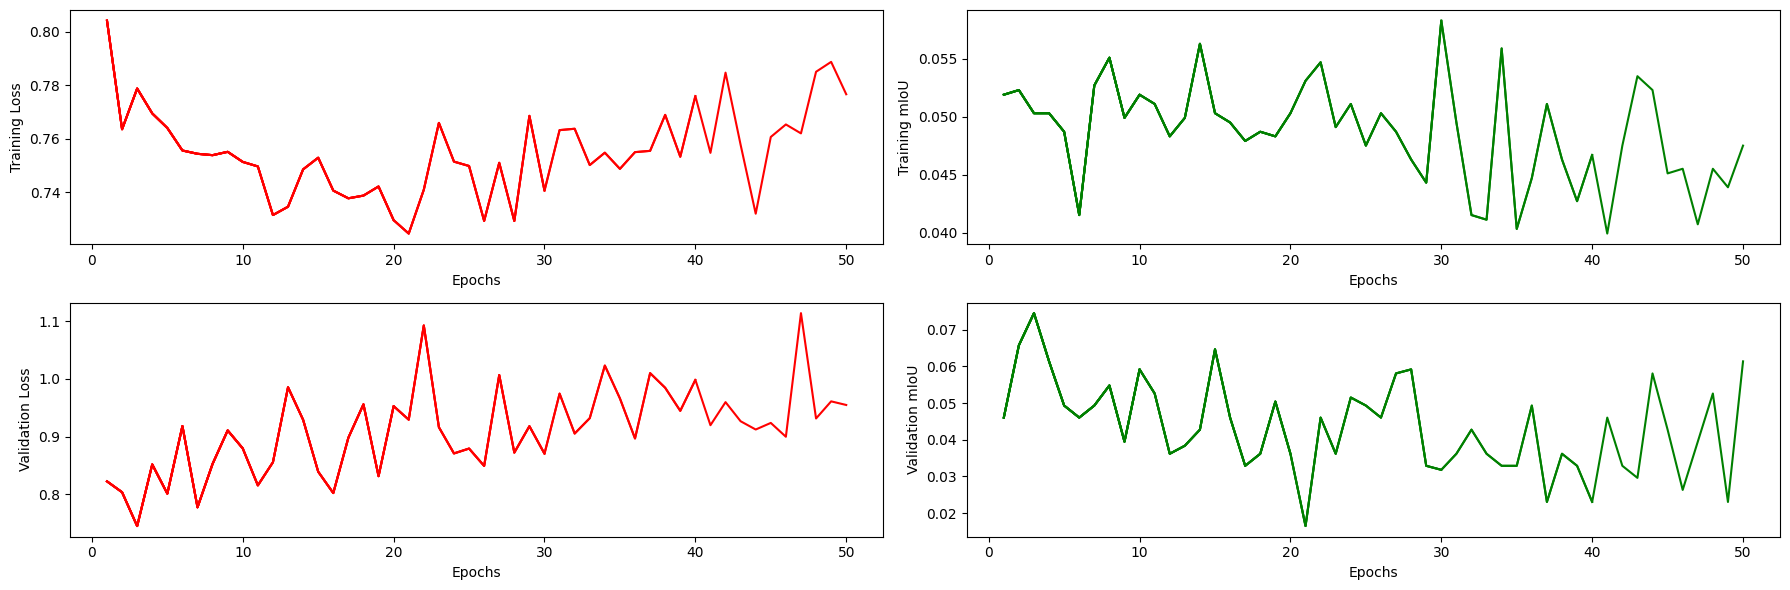

In [ ]:
import torch.optim as optim
import copy
import time
import matplotlib.pyplot as plt
# Reinitialize the model
model = []

model_input_size = 7438
model = SimpleTransformer(model_input_size)
optimizer = optim.Adam(model.parameters())
model = model.to(device)


EPOCHS = 100

best_valid_loss = float('inf')

train_losses = []
train_accs = []

val_losses = []
val_accs = []

## For plotting the metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,6))

for epoch in trange(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

    if valid_loss < best_valid_loss or (((epoch+1) % 10) == 0):
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_save_path, f"model_epoch_{epoch}.pt"))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if ((epoch+1) % 10) == 0:
      epoch_range = range(1, len(train_losses)+1)
      ## Training plots
      # Loss
      axes[0, 0].plot(epoch_range, train_losses, color='r')
      axes[0, 0].set_xlabel('Epochs')
      axes[0, 0].set_ylabel('Training Loss')

      # mIoU
      axes[0, 1].plot(epoch_range, train_accs, color='g')
      axes[0, 1].set_xlabel('Epochs')
      axes[0, 1].set_ylabel('Training mIoU')

      ## Validation plots
      axes[1, 0].plot(epoch_range, val_losses, color='r')
      axes[1, 0].set_xlabel('Epochs')
      axes[1, 0].set_ylabel('Validation Loss')

      # mIoU
      axes[1, 1].plot(epoch_range, val_accs, color='g')
      axes[1, 1].set_xlabel('Epochs')
      axes[1, 1].set_ylabel('Validation mIoU')

      # Showing the plots
      plt.tight_layout()
      fig.savefig(os.path.join(graph_save_path, f"metrics_epoch_{epoch}.png"))

-----

## SCRATCH

This section is all previous stuff we aren't sure if we still want/need.

In [ ]:
rarityDistribution = pd.pivot_table(
   printings[['Set Code', 'Released', 'Rarity']],
   index = ['Set Code', 'Released'],
   columns = 'Rarity',
   values = 'Rarity',
   aggfunc = {'Rarity': 'count'},
   fill_value = 0
)
# Order the rarity columns in a sane way
rarityDistribution = rarityDistribution[rarityList]
# Count the total number of cards in these sets
rarityDistribution['Total'] = rarityDistribution.sum(axis = 1)

rarityDistribution.sort_values(by = ['Released'])


Does this need to be moderated by the standard deviation of the printings...?

For a while, the common distribution of cards in a sealed booster pack were as follows:
- 11 commons
- 3 uncommons
- 1 rare
- 1 land

The rare slot ususally has a 1 in 8 chance of being a mythic.

In [ ]:
density = rarityDistribution.query('Total > 75 & common > 10 & uncommon > 2 & rare > 0').copy()
density['common'] = density.apply(lambda row: 1 - (row['common'] - 11) / row['common'], axis = 1)
density['uncommon'] = density.apply(lambda row: 1 - (row['uncommon'] - 3) / row['uncommon'], axis = 1)
density['rare'] = density.apply(lambda row: 7/8 * (1 - (row['rare'] - 1) / row['rare']), axis = 1)
density['mythic'] = density.apply(lambda row: 1/8 * (1 - (row['mythic'] - 1) / row['mythic']) if row['mythic'] > 0 else 0, axis = 1)
density.sort_values(by = ['Released'])

In [ ]:
# This block represents the values that a given card in a set is a given rarity
rarities = rarityDistribution.copy()
packDistribution = {
    'common': 10/14,
    'uncommon': 3/14,
    'rare': 1/14,
    'mythic': 0
}
packDistributionMythic = {
    'common': 10/14,
    'uncommon': 3/14,
    'rare': 7/112,
    'mythic': 1/112
}
raritiesNonMythic = rarities.query('Total > 75 & mythic == 0').copy()
raritiesMythic = rarities.query('Total > 75 & mythic > 0').copy()


for column in raritiesNonMythic.columns:
    if column != 'Total':
        raritiesNonMythic['normalized' + column] = raritiesNonMythic[column] * packDistribution[column]/raritiesNonMythic['Total']
for column in raritiesMythic.columns:
    if column != 'Total':
        raritiesMythic['normalized' + column] = raritiesMythic[column] * packDistributionMythic[column]/raritiesMythic['Total']

raritiesNonMythic = raritiesNonMythic.drop(columns=['common', 'uncommon', 'rare', 'mythic', 'Total'])
raritiesMythic = raritiesMythic.drop(columns=['common', 'uncommon', 'rare', 'mythic', 'Total'])

normalizedRarities = pd.concat([raritiesNonMythic, raritiesMythic])
normalizedRarities['normalizedTotal'] = normalizedRarities.sum(axis = 1)
for column in raritiesNonMythic.columns:
    if column != 'Total':
        raritiesNonMythic['normalized' + column] = raritiesNonMythic[column]/normalizedRarities['normalizedTotal']
for column in normalizedRarities.columns:
    if column != 'normalizedTotal':
        normalizedRarities[column] = normalizedRarities[column]/normalizedRarities['normalizedTotal']
normalizedRarities = normalizedRarities.drop(columns=['normalizedTotals'])

normalizedRarities